# Insurance Claim Prediction
### https://datahack.analyticsvidhya.com/contest/dataverse/#ProblemStatement

In [1]:
# Import Packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
import sys
import dtale

from catboost import CatBoostClassifier

%matplotlib inline


# Folder Structure
SCRIPT_DIR = (os.path.dirname(os.path.realpath("__file__")))
DATA_DIR = os.path.join(os.path.dirname(SCRIPT_DIR), "data")

# Read Data
train = pd.read_csv(f"{DATA_DIR}/train-file")
test = pd.read_csv(f"{DATA_DIR}/test-file")

print(train.shape, test.shape)
train.sample()

(58592, 44) (39063, 43)


,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
21834,ID21835,1.223246,0.1,0.509615,C14,7788,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2,No,Yes,No,Yes,No,Drum,1197,4,Manual,5,Electric,4.8,3845,1735,1530,1335,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,1


In [2]:
dtale.show(train)

In [3]:
idx = ['policy_id']

yes_no_cols = [
    'is_speed_alert', 'is_ecw', 'is_day_night_rear_view_mirror',
    'is_driver_seat_height_adjustable', 'is_power_steering',
    'is_central_locking', 'is_power_door_locks', 'is_brake_assist',
    'is_rear_window_defogger', 'is_rear_window_washer',
    'is_rear_window_wiper', 'is_front_fog_lights', 'is_parking_camera',
    'is_parking_sensors', 'is_tpms', 'is_adjustable_steering', 'is_esc',
]

categorical_features = yes_no_cols + [
    'steering_type', 'transmission_type', 'rear_brakes_type',
    'engine_type', 'fuel_type', 'model', 'segment',
    'make', 'area_cluster'
]

numerical_features = [
    'ncap_rating', 'gross_weight', 'height', 'width', 'length',
    'turning_radius', 'displacement', 'airbags', 'population_density',
    'age_of_policyholder', 'age_of_car', 'policy_tenure',
    'gear_box', 'cylinder'
]

target = ['is_claim']

feature_target_mapping = {
    "idx": idx,
    "categorical_features": categorical_features,
    "numerical_features": numerical_features,
    "target": target
}

## ToDo
age_of_car == age_of_policyholder

In [4]:
train['is_claim'].value_counts()

0    54844
1     3748
Name: is_claim, dtype: int64

In [5]:
# max_power
bhp_regex = r'(\d*.\d*)bhp'
rpm_regex = r'@(\d*)rpm'

# max_torque
nm_regex = r'(\d*.*\d*)Nm@'


def encode_yes_no_cols(df, yes_no_cols):

    for col in yes_no_cols:
        df[col] = df[col].map({"Yes": 1, "No": 0})

    return df


def get_bhp_rpm_from_power(df, bhp_regex, rpm_regex):

    df['bhp_power'] = df['max_power'].str.extract(bhp_regex)
    df['rpm_power'] = df['max_power'].str.extract(rpm_regex)

    return df


def get_Nm_rpm_from_torque(df, nm_regex, rpm_regex):

    df['bhp_torque'] = df['max_torque'].str.extract(nm_regex)
    df['rpm_torque'] = df['max_torque'].str.extract(rpm_regex)

    return df


def convert_categorical_features(df, categorical_features):

    for col in categorical_features:
        df[col] = df[col].astype(str)

    return df


def convert_numerical_features(df, numerical_features):

    for col in numerical_features:
        df[col] = df[col].astype(float)

    return df


def preprocess_data(df, obj=feature_target_mapping):

    shape_before = df.shape
    # print(shape_before)

    df = encode_yes_no_cols(df, yes_no_cols=obj.get('yes_no_cols'))
    df = get_bhp_rpm_from_power(df, bhp_regex=obj.get('bhp_regex'), rpm_regex=obj.get('rpm_regex'))
    df = get_Nm_rpm_from_torque(df, nm_regex=obj.get('nm_regex'), rpm_regex=obj.get('rpm_regex'))
    # Update Feature Target Mapping
    feature_target_mapping['numerical_features'].extend(['bhp_power', 'rpm_power'])
    feature_target_mapping['numerical_features'].extend(['bhp_torque', 'rpm_torque'])
    feature_target_mapping['numerical_features'] = list(set(feature_target_mapping['numerical_features']))
    
    df = convert_categorical_features(df, categorical_features=obj.get('categorical_features'))
    df = convert_numerical_features(df, numerical_features=obj.get('numerical_features'))

    df = df.set_index(obj.get('idx'))

    feature_target_mapping['features'] = feature_target_mapping['categorical_features'] + feature_target_mapping['numerical_features']

    shape_after = df.shape
    # print(shape_after)

    assert shape_before[0] == shape_after[0]

    return df

In [6]:
obj = {**feature_target_mapping, **{
        "yes_no_cols": yes_no_cols,
        "bhp_regex": bhp_regex,
        "rpm_regex": rpm_regex,
        "nm_regex": nm_regex
    }
}


train = preprocess_data(train, obj)
test = preprocess_data(test, obj)

In [7]:
# train.loc[(train['max_torque'] == "82.1Nm@3400rpm")]

In [84]:
features = feature_target_mapping['features']
target = feature_target_mapping['target']

Xy = train.reindex(features + target, axis=1)
X = Xy.reindex(features, axis=1)
y = Xy.reindex(target, axis=1)

In [85]:
from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X, y = undersample.fit_resample(X, y)

In [86]:
# Random Sampling

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)


print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(4197, 44) (4197, 1) (1799, 44) (1799, 1) (1500, 44) (1500, 1)


In [87]:
y_val.value_counts(), y_test.value_counts()

(is_claim
 0           900
 1           899
 dtype: int64,
 is_claim
 0           750
 1           750
 dtype: int64)

In [88]:
# ---------------------
# Train-Val-Test Pools
# ---------------------

from catboost import Pool

# initialize Pool
full_pool = Pool(
  X,
  y,
  cat_features=feature_target_mapping['categorical_features']
)

train_pool = Pool(
  X_train,
  y_train,
  cat_features=feature_target_mapping['categorical_features']
)
val_pool = Pool(
  X_val,
  y_val,
  cat_features=feature_target_mapping['categorical_features']
)
test_pool = Pool(
  X_test,
  y_test,
  cat_features=feature_target_mapping['categorical_features']
)

# Submission Pool
submission_pool = Pool(
  test.reindex(features, axis=1),
  cat_features=feature_target_mapping['categorical_features']
)


In [89]:
# y.value_counts()

In [101]:
version = 0.1
iterations = 10000
max_depth = 16
learning_rate = 1e-5
eval_metric = 'F1'
early_stopping_rounds = 100
# l2_leaf_reg = 1

# ---------------------
# Classification
# ---------------------

from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=iterations,
    max_depth=max_depth,
    learning_rate=learning_rate,
    eval_metric=eval_metric,
    verbose=False,
    early_stopping_rounds=early_stopping_rounds,
    # l2_leaf_reg = l2_leaf_reg,
    random_seed=42
)

# train the model
model.fit(train_pool, eval_set=val_pool, plot=True) # 

# make the prediction using the resulting model
preds_class = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)
print("class = ", preds_class)
print("proba = ", preds_proba)

feature_imp_df = pd.DataFrame.from_dict(dict(zip(model.feature_names_, model.feature_importances_)), orient='index', columns=['importance']).reset_index().rename(columns={'index': 'feature'}).sort_values('importance', ascending=False)
feature_imp_df


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

class =  [0 1 1 ... 0 0 1]
proba =  [[0.50019952 0.49980048]
 [0.49957615 0.50042385]
 [0.49993033 0.50006967]
 ...
 [0.50018609 0.49981391]
 [0.50006269 0.49993731]
 [0.49991332 0.50008668]]


,feature,importance
28,age_of_car,23.436356
35,policy_tenure,18.922708
25,area_cluster,14.949096
32,age_of_policyholder,9.354448
40,population_density,6.004713
17,steering_type,3.545702
21,fuel_type,3.117560
20,engine_type,2.566673
22,model,2.524007
23,segment,2.391372


In [102]:
feature_imp_df.loc[(feature_imp_df['importance'] < 1), 'feature'].unique()

array(['bhp_power', 'length', 'displacement', 'width', 'bhp_torque',
       'rpm_torque', 'turning_radius', 'rpm_power', 'is_ecw',
       'is_power_door_locks', 'ncap_rating',
       'is_day_night_rear_view_mirror', 'is_central_locking', 'gear_box',
       'is_adjustable_steering', 'airbags', 'is_parking_camera',
       'transmission_type', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_esc', 'cylinder',
       'is_driver_seat_height_adjustable', 'is_rear_window_wiper',
       'is_front_fog_lights', 'is_brake_assist', 'is_parking_sensors',
       'is_speed_alert', 'is_power_steering', 'is_tpms',
       'rear_brakes_type'], dtype=object)

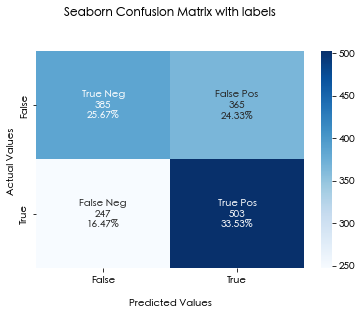

In [105]:
# ------------------------
# Classification
# ------------------------

def plot_confusion_matrix(y_test, y_pred):

    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cf_matrix = confusion_matrix(y_test, y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()


plot_confusion_matrix(y_test, y_pred=preds_class)

Accuracy of the classifier is: 0.592
Precision Score of the classifier is: 0.5794930875576036
Recall Score of the classifier is: 0.6706666666666666
F1 Score of the classifier is: 0.6217552533992584
True Positive : 385
False Positive : 365
False Negative : 247
True Negative : 503


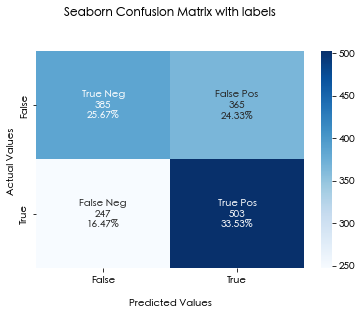

In [106]:
def get_classification_eval_metrics(y_test, y_pred):

    from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score#, plot_confusion_matrix
    import matplotlib.pyplot as plt

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the classifier is: {accuracy}")
    precision = precision_score(y_test, y_pred)
    print(f"Precision Score of the classifier is: {precision}")
    recall = recall_score(y_test, y_pred)
    print(f"Recall Score of the classifier is: {recall}")
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score of the classifier is: {f1}")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"True Positive : {conf_matrix[0][0]}\nFalse Positive : {conf_matrix[0][1]}\nFalse Negative : {conf_matrix[1][0]}\nTrue Negative : {conf_matrix[1][1]}")
    plot_confusion_matrix(y_test, y_pred)
    plt.show()
    
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_classification_eval_metrics(y_test, y_pred=preds_class)

AUC for our classifier is: 0.6314453333333334


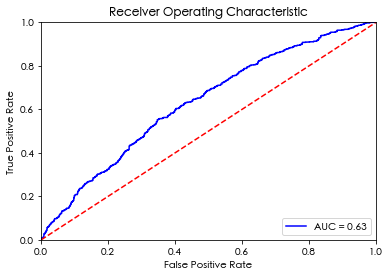

In [107]:
def get_roc_auc_curve(model, X_test, y_test):

    # Importing all necessary libraries
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    class_probabilities = model.predict_proba(X_test)
    preds = class_probabilities[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # Printing AUC
    print(f"AUC for our classifier is: {roc_auc}")

    # Plotting the ROC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

get_roc_auc_curve(model, X_test, y_test)

In [108]:
# # thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.7]
# thresholds = [0.4, 0.5, 0.6]

# def threshold_evaluations(model, df, thresholds=[0.5, 0.4, 0.6]):

#     df['proba'] = model.predict_proba(df.reindex(model.feature_names_, axis=1))[:,1]
#     # print(df['proba'].value_counts())

#     for threshold in thresholds:

#         print(f'\nThreshold: {threshold}')
#         df.loc[(df['proba'] >= threshold), f'y_pred_{threshold}'] = 1
#         # print(df[['proba', f'y_pred_{threshold}']])
#         # print(df[f'y_pred_{threshold}'].value_counts())
#         df[f'y_pred_{threshold}'] = df[f'y_pred_{threshold}'].fillna(0)
#         # print(df[f'y_pred_{threshold}'].value_counts())
#         get_classification_eval_metrics(y_test, y_pred=df[f'y_pred_{threshold}'])

# threshold_evaluations(model, X_test, thresholds=thresholds)

In [109]:
# Plot the tree to understand the split
model.plot_tree(0, pool=train_pool)

KeyboardInterrupt: 

In [ ]:
# # Check visualisation of test and pred set to understand the predictions accuracy.
# pred_df = pd.DataFrame({'y_test': y_test, 'y_pred': preds_class})
# dtale.show(pred_df)

In [110]:
test.shape

(39063, 48)

In [111]:
# Save file for submission

test['proba'] = model.predict_proba(submission_pool)[:, 1]
test.loc[(test['proba'] >= 0.5), target[0]] = 1
test[feature_target_mapping['target'][0]] = test[feature_target_mapping['target'][0]].fillna(0)
test[feature_target_mapping['target'][0]] = test[feature_target_mapping['target'][0]].astype(int)

test

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,bhp_power,rpm_power,bhp_torque,rpm_torque,proba,is_claim
policy_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID58593,0.341732,0.00,0.586538,C3,4076.0,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2.0,0,0,0,1,0,Drum,796.0,3.0,Manual,5.0,Power,4.60,3445.0,1515.0,1475.0,1185.0,0,0,0,0,0,0,0,1,0,0,0,1,0.0,40.36,6000.0,60.0,3500.0,0.500476,1
ID58594,0.307241,0.13,0.442308,C8,8794.0,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2.0,0,1,0,1,0,Drum,1197.0,4.0,Manual,5.0,Electric,4.80,3845.0,1735.0,1530.0,1335.0,1,0,0,0,1,1,1,1,1,1,1,1,2.0,88.50,6000.0,113.0,4400.0,0.499690,0
ID58595,0.327924,0.12,0.451923,C8,8794.0,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2.0,0,0,0,0,1,Drum,999.0,3.0,Automatic,5.0,Electric,5.00,3731.0,1579.0,1490.0,1155.0,0,0,0,0,0,1,1,1,0,1,1,1,2.0,67.06,5500.0,91.0,4250.0,0.499884,0
ID58596,0.782654,0.01,0.461538,C5,34738.0,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2.0,0,0,0,1,0,Drum,796.0,3.0,Manual,5.0,Power,4.60,3445.0,1515.0,1475.0,1185.0,0,0,0,0,0,0,0,1,0,0,0,1,0.0,40.36,6000.0,60.0,3500.0,0.499877,0
ID58597,1.233404,0.02,0.634615,C5,34738.0,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2.0,0,0,0,1,0,Drum,796.0,3.0,Manual,5.0,Power,4.60,3445.0,1515.0,1475.0,1185.0,0,0,0,0,0,0,0,1,0,0,0,1,0.0,40.36,6000.0,60.0,3500.0,0.499838,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID97651,0.047982,0.15,0.740385,C2,27003.0,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2.0,0,1,0,1,0,Drum,1197.0,4.0,Manual,5.0,Electric,4.80,3845.0,1735.0,1530.0,1335.0,1,0,0,0,1,1,1,1,1,1,1,1,2.0,88.50,6000.0,113.0,4400.0,0.499851,0
ID97652,1.224838,0.05,0.509615,C8,8794.0,3,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,1.5 L U2 CRDi,6.0,1,1,1,1,1,Disc,1493.0,4.0,Automatic,6.0,Power,5.20,4300.0,1790.0,1635.0,1720.0,1,1,1,1,1,1,1,1,1,0,1,1,3.0,113.45,4000.0,250.0,2750.0,0.500268,1
ID97653,0.520287,0.12,0.355769,C6,13051.0,1,B2,M7,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K Series Engine,6.0,1,1,0,1,1,Drum,1197.0,4.0,Automatic,5.0,Electric,4.85,3990.0,1745.0,1500.0,1410.0,1,1,1,1,1,1,1,1,1,1,1,1,0.0,88.50,6000.0,113.0,4400.0,0.500043,1


In [112]:
submission = test.reset_index()[[feature_target_mapping['idx'][0], feature_target_mapping['target'][0]]]#.set_index('id')

file_name = f"v{version}_cb_{eval_metric}_{max_depth}_{learning_rate}-{accuracy}_{precision}_{recall}_{f1}.csv"
print(file_name)
submission.to_csv(f'{DATA_DIR}/{file_name}', index=False) # _{l2}
submission

v0.1_cb_F1_16_1e-05-0.592_0.5794930875576036_0.6706666666666666_0.6217552533992584.csv


,policy_id,is_claim
0,ID58593,1
1,ID58594,0
2,ID58595,0
3,ID58596,0
4,ID58597,0
...,...,...
39058,ID97651,0
39059,ID97652,1
39060,ID97653,1
39061,ID97654,1
